## Introduction

The task is to create an elo rating system containing all D1 College basketball schools (mens' and womens'). All data used was from Kaggle.

Some notes on data:

Mreg, Wreg:
- Mreg contains regular season and conference tournament game results for the Mens' starting in 1985.
- Wreg contains the same for the Womens' starting in 1998.
- DayNum is an integer value with range 0-132, DayNum 132 is always selection Sunday.

Mtourn, Wtourn:
- Results of NCAA Tournament games.
- DayNum 154 is always the NCAA Tournament Championship.

Mconf_tourn, Wconf_tourn:
- Doesn't include results, but was used to identify which games are conference tournament games.

Mgame_city, Wgame_city:
- Used to identify where a game was played.


In [106]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from geopy.geocoders import Nominatim
from scipy.integrate import cumtrapz
from scipy.optimize import curve_fit
import warnings
from sklearn.linear_model import LogisticRegression
warnings.filterwarnings('ignore')
%cd C:\Users\18594\Documents\Projects\Kaggle\March Mania

Mteams = pd.read_csv('Mteams.csv')
Wteams = pd.read_csv('Wteams.csv')
Mreg = pd.read_csv('MRegularSeasonCompactResults.csv')
Wreg = pd.read_csv('WRegularSeasonCompactResults.csv')
Mtourn = pd.read_csv('MNCAATourneyCompactResults.csv')
Wtourn = pd.read_csv('WNCAATourneyCompactResults.csv')
Mconf_tourn = pd.read_csv('MConferenceTourneyGames.csv')
Wconf_tourn = pd.read_csv('WConferenceTourneyGames.csv')
city = pd.read_csv('Cities.csv')
Mgame_city = pd.read_csv('MGameCities.csv')
Wgame_city = pd.read_csv('WGameCities.csv')
Mteam_conf = pd.read_csv('MTeamConferences.csv')
Wteam_conf = pd.read_csv('WTeamConferences.csv')
Mteam_conf = Mteam_conf[Mteam_conf['Season'] == 2025]
Wteam_conf = Wteam_conf[Wteam_conf['Season'] == 2025]
Mteams = Mteams.merge(Mteam_conf[['TeamID', 'ConfAbbrev']], on='TeamID', how='left')
Mteams.rename(columns = {'ConfAbbrev':'Conf'}, inplace = True)
Wteams = Wteams.merge(Wteam_conf[['TeamID', 'ConfAbbrev']], on='TeamID', how='left')
Wteams.rename(columns= {'ConfAbbrev':'Conf'}, inplace = True)
#Mtourn_teams = pd.read_csv('MNCAATourneySeeds.csv')
#Wtourn_teams = pd.read_csv('WNCAATourneySeeds.csv')
#Mtourn_teams = Mtourn_teams.loc[Mtourn_teams['Season'] == 2025, 'TeamID']
#Wtourn_teams = Wtourn_teams.loc[Wtourn_teams['Season'] == 2025, 'TeamID']
#Mtourn_teams = pd.DataFrame(Mtourn_teams,columns=['TeamID'])
#Wtourn_teams = pd.DataFrame(Wtourn_teams,columns=['TeamID'])


print(Mteams.head())
print(Wreg.head())
print(Mtourn.head())
print(Mconf_tourn.head())
print(city.head())
print(Mgame_city.head())
print(Wtourn_teams.head())

C:\Users\18594\Documents\Projects\Kaggle\March Mania
   TeamID     TeamName  FirstD1Season  LastD1Season  Conf
0    1101  Abilene Chr           2014          2025   wac
1    1102    Air Force           1985          2025   mwc
2    1103        Akron           1985          2025   mac
3    1104      Alabama           1985          2025   sec
4    1105  Alabama A&M           2000          2025  swac
   Season  DayNum  WTeamID  WScore  LTeamID  LScore WLoc  NumOT
0    1998      18     3104      91     3202      41    H      0
1    1998      18     3163      87     3221      76    H      0
2    1998      18     3222      66     3261      59    H      0
3    1998      18     3307      69     3365      62    H      0
4    1998      18     3349     115     3411      35    H      0
   Season  DayNum  WTeamID  WScore  LTeamID  LScore WLoc  NumOT
0    1985     136     1116      63     1234      54    N      0
1    1985     136     1120      59     1345      58    N      0
2    1985     136     1

### Identifying Type of Game (Regular Season, Conference Tournament, NCAA Tournament)

I am planning to apply weights for each type of game, so I derive the type and concatenate all games into one dataframe.

In [46]:
#Mreg also contains conference games but that will be changed
Mreg['type'] = 'regular season'
Wreg['type'] = 'regular season'

#Conference games will have matching observations with the same Season, DayNum, WTeamID, and LTeamID in reg dataframe and conf_tourn dataframes, using this we can
#check games where all 4 values match and assign them as conference games
Mreg = Mreg.merge(Mconf_tourn[['Season', 'DayNum', 'WTeamID', 'LTeamID']], 
                  on=['Season', 'DayNum', 'WTeamID', 'LTeamID'], 
                  how='left', indicator=True)
Wreg = Wreg.merge(Wconf_tourn[['Season', 'DayNum', 'WTeamID', 'LTeamID']], 
                  on=['Season', 'DayNum', 'WTeamID', 'LTeamID'], 
                  how='left', indicator=True)

Mreg.loc[Mreg['_merge'] == 'both', 'type'] = 'conf tournament'
Wreg.loc[Wreg['_merge'] == 'both', 'type'] = 'conf tournament'

Mreg = Mreg.drop(columns=['_merge'])
Wreg = Wreg.drop(columns=['_merge'])

#All games in these dataframes are ncaa tournament games
Wtourn['type'] = Mtourn['type'] = 'ncaa tournament'

Mgames = pd.concat([Mreg, Mtourn])
Wgames = pd.concat([Wreg, Wtourn])

#Sort by ascending Season and then ascedning DayNum.
Mgames = Mgames.sort_values(by=['Season', 'DayNum'], ascending=[True, True]).reset_index(drop=True)
Wgames = Wgames.sort_values(by=['Season', 'DayNum'], ascending=[True, True]).reset_index(drop=True)

### Deriving Home/Away Team

The home and away teams are not directly given to us, however we are given the winning team, the losing team, and the location (home, away, or neutral) of the winning team. We can use this information to deduce the home and away teams. For neutral site games we assigned the winning team to home and the losing team to away.

In [47]:
# Deriving Home and Away Teams
Mgames['HTeamID'] = Mgames['WTeamID'].where(Mgames['WLoc'] == 'H', Mgames['LTeamID'])
Mgames['ATeamID'] = Mgames['LTeamID'].where(Mgames['WLoc'] == 'H', Mgames['WTeamID'])
Wgames['HTeamID'] = Wgames['WTeamID'].where(Wgames['WLoc'] == 'H', Wgames['LTeamID'])
Wgames['ATeamID'] = Wgames['LTeamID'].where(Wgames['WLoc'] == 'H', Wgames['WTeamID'])

# For 'N' (neutral location), we set HTeamID and ATeamID to WTeamID and LTeamID respectively
Mgames.loc[Mgames['WLoc'] == 'N', ['HTeamID', 'ATeamID']] = Mgames.loc[Mgames['WLoc'] == 'N', ['WTeamID', 'LTeamID']].values
Wgames.loc[Wgames['WLoc'] == 'N', ['HTeamID', 'ATeamID']] = Wgames.loc[Wgames['WLoc'] == 'N', ['WTeamID', 'LTeamID']].values

#Some earlier games(late 1900s) only included the winning and losing team, because we will use margin of victory later, its easier to just dispose of games missing the score, as they
# will have virtually no impact on the current elo ratings anyways.
Mgames = Mgames.dropna(subset=['WScore'])
Wgames = Wgames.dropna(subset=['LScore'])

### Travel Distance

I want to calculate the euclidean (straight-line) distance a team is away from the city the game is in. So the first step is to get the longitude and latitude coords for each city.

In [48]:
from geopy.geocoders import Nominatim
import time
import pandas as pd

# Initialize the geolocator with a longer timeout
geolocator = Nominatim(user_agent="city_coordinates", timeout=10)  # Set timeout to 10 seconds

def get_coordinates(city, state):
    try:
        # Geocode the city and state
        location = geolocator.geocode(f"{city}, {state}")
        if location:
            return location.latitude, location.longitude
        else:
            return None, None  # Return None if not found
    except Exception as e:
        print(f"Error geocoding {city}, {state}: {e}")
        return None, None  # Return None if there's an error
    finally:
        # Adding a small delay to avoid hitting rate limits
        time.sleep(1)  # Delay of 1 second between requests


#city[['Latitude', 'Longitude']] = city.apply(lambda row: get_coordinates(row['City'], row['State']), axis=1, result_type="expand")
#city.to_csv('citycoords.csv', index=False)
city = pd.read_csv('citycoords.csv')

### Obtaining Each Schools Coords

Originally I tried a similiar process using the school's name to obtain coords but this led to inaccuracies. Plan B was to calculate where a team played most of their home games at and assign that as their coordinates.

I am unaware of any schools that move locations like how proffesional franchises do, so this should work fine.

A situation I did not explore was how data was handled for teams whose home games where not in their stadium. For example in the 2017-2018 season the University of Cincinnati played their home games at Northern Kentucky University due to construction. A higher care for situations like this may lead to minor improvements in the rating system.

In [49]:
# Merge Mgames with Mgame_city to get CityID for each game
merged_df = Mgames.merge(Mgame_city, on=['WTeamID', 'LTeamID', 'Season', 'DayNum'])

# Remove neutral games since we can't determine a home city for those
home_games = merged_df[merged_df['WLoc'] != 'N']

# Find the most common CityID for each home team (HTeamID)
home_city_mode = (
    home_games.groupby('HTeamID')['CityID']
    .agg(lambda x: x.mode().iloc[0])  # Get the most frequently occurring CityID
    .reset_index()
)

# Map the most common CityID back to Mgames
Mgames['HomeCityID'] = Mgames['HTeamID'].map(home_city_mode.set_index('HTeamID')['CityID'])

# Set HomeCityID to None for neutral-site games
Mgames.loc[Mgames['WLoc'] == 'N', 'HomeCityID'] = None


In [50]:
# Merge Mgames with Mgame_city to get CityID for each game
W_merged_df = Wgames.merge(Wgame_city, on=['WTeamID', 'LTeamID', 'Season', 'DayNum'])

# Remove neutral games since we can't determine a home city for those
W_home_games = W_merged_df[W_merged_df['WLoc'] != 'N']

# Find the most common CityID for each home team (HTeamID)
W_home_city_mode = (
    W_home_games.groupby('HTeamID')['CityID']
    .agg(lambda x: x.mode().iloc[0])  # Get the most frequently occurring CityID
    .reset_index()
)

# Map the most common CityID back to Mgames
Wgames['HomeCityID'] = Wgames['HTeamID'].map(W_home_city_mode.set_index('HTeamID')['CityID'])

# Set HomeCityID to None for neutral-site games
Wgames.loc[Wgames['WLoc'] == 'N', 'HomeCityID'] = None

Simply just merging dataframes to get the coordinates for each school. I did womens and mens seperately, so combining both and getting rid of duplicates is an area for improved computing cost.

In [51]:
#Merge with city dataframe to get latitude & longitude of each school
college_coords = home_city_mode.merge(
    city[['CityID', 'Latitude', 'Longitude']], 
    left_on='CityID', 
    right_on='CityID', 
    how='left'
)

#Keep necessary columns and handle NaNs. (There was no missing data for any current D1 schools)
college_coords = college_coords[['HTeamID', 'CityID', 'Latitude', 'Longitude']]
college_coords.dropna(inplace=True)  # Ensure no missing values before conversion
college_coords['CityID'] = college_coords['CityID'].astype(int)  # Convert safely

college_coords

,HTeamID,CityID,Latitude,Longitude
0,1101,4001,32.446450,-99.747591
1,1102,4356,38.978759,-104.864389
2,1103,4002,41.083064,-81.518485
3,1104,4353,33.209561,-87.567526
4,1105,4245,34.788979,-86.571937
...,...,...,...,...
364,1476,4490,42.024544,-71.128659
365,1477,4488,33.243649,-95.902693
366,1478,4340,43.048122,-76.147424
367,1479,4508,42.129471,-80.085269


In [52]:
# Step 5: Merge with city dataframe to get latitude & longitude (only once)
W_college_coords = W_home_city_mode.merge(
    city[['CityID', 'Latitude', 'Longitude']], 
    left_on='CityID', 
    right_on='CityID', 
    how='left'
)

# Step 6: Keep necessary columns and handle NaNs
W_college_coords = W_college_coords[['HTeamID', 'CityID', 'Latitude', 'Longitude']]
W_college_coords.dropna(inplace=True)  # Ensure no missing values before conversion
W_college_coords['CityID'] = W_college_coords['CityID'].astype(int)  # Convert safely

In [53]:
Mteam_coords = pd.merge(Mteams, college_coords[['HTeamID', 'Latitude', 'Longitude']], 
                     left_on='TeamID', right_on='HTeamID', 
                     how='left')

#There was some missing coords but none for any semi-recent or current D1 Programs
missing_coords = Mteam_coords[Mteam_coords['Latitude'].isna() | Mteam_coords['Longitude'].isna()]

In [57]:
Wteam_coords = pd.merge(Wteams, W_college_coords[['HTeamID', 'Latitude', 'Longitude']], 
                     left_on='TeamID', right_on='HTeamID', 
                     how='left')

#Similliarly, no missing coords for any semi-recent or current D1 Programs
Wmissing_coords = Wteam_coords[Wteam_coords['Latitude'].isna() | Wteam_coords['Longitude'].isna()]

### Calulating Travel Distance

Simple funciton calculating euclidean distance between a school and the game location.

In [58]:
Miles_per_Lat = 69

def euclidean_distance(lat1, lon1, lat2, lon2):
    avg_lat = np.radians((lat1+lat2)/2)
    Miles_per_lon = Miles_per_Lat * np.cos(avg_lat)

    dlat = (lat2-lat1) * Miles_per_Lat
    dlon = (lon2-lon1) * Miles_per_lon

    return np.sqrt(dlat**2+dlon**2)

In [59]:
#Merging to obtain coords for the two teams and game location

Mgames = Mgames.merge(Mgame_city[['Season', 'DayNum', 'WTeamID', 'LTeamID', 'CityID']],
                      on=['Season', 'DayNum', 'WTeamID', 'LTeamID'],
                      how='left'
                      )
Mgames = Mgames.merge(city[['CityID', 'Latitude', 'Longitude']],
                      on=['CityID'],
                      how='left').rename(columns={'Latitude' : 'court_Latitude', 'Longitude' : 'court_Longitude'})
Mgames = Mgames.merge(Mteam_coords[['TeamID', 'Latitude', 'Longitude']],
                      left_on=['HTeamID'],
                      right_on=['TeamID'],
                      how='left').rename(columns={'Latitude' : 'home_Latitude', 'Longitude' : 'home_Longitude'})
Mgames = Mgames.merge(Mteam_coords[['TeamID', 'Latitude', 'Longitude']],
                      left_on=['ATeamID'],
                      right_on=['TeamID'],
                      how='left').rename(columns={'Latitude' : 'away_Latitude', 'Longitude' : 'away_Longitude'})

In [60]:
Wgames = Wgames.merge(Wgame_city[['Season', 'DayNum', 'WTeamID', 'LTeamID', 'CityID']],
                      on=['Season', 'DayNum', 'WTeamID', 'LTeamID'],
                      how='left'
                      )
Wgames = Wgames.merge(city[['CityID', 'Latitude', 'Longitude']],
                      on=['CityID'],
                      how='left').rename(columns={'Latitude' : 'court_Latitude', 'Longitude' : 'court_Longitude'})
Wgames = Wgames.merge(Wteam_coords[['TeamID', 'Latitude', 'Longitude']],
                      left_on=['HTeamID'],
                      right_on=['TeamID'],
                      how='left').rename(columns={'Latitude' : 'home_Latitude', 'Longitude' : 'home_Longitude'})
Wgames = Wgames.merge(Wteam_coords[['TeamID', 'Latitude', 'Longitude']],
                      left_on=['ATeamID'],
                      right_on=['TeamID'],
                      how='left').rename(columns={'Latitude' : 'away_Latitude', 'Longitude' : 'away_Longitude'})

In [61]:
#Dropping the games which include those schools with missing coords
Mgames.dropna(subset=['away_Latitude', 'away_Longitude'], inplace=True)


In [62]:
Wgames.dropna(subset=['away_Latitude', 'away_Longitude'], inplace=True)

In [63]:
Mgames['home_travel_distance'] = euclidean_distance(Mgames['home_Latitude'].values, Mgames['home_Longitude'].values,
                                                    Mgames['court_Latitude'].values, Mgames['court_Longitude'].values
                                                   )

Mgames['away_travel_distance'] = euclidean_distance(Mgames['away_Latitude'].values, Mgames['away_Longitude'].values,
                                                    Mgames['court_Latitude'].values, Mgames['court_Longitude'].values)

In [64]:
Wgames['home_travel_distance'] = euclidean_distance(Wgames['home_Latitude'].values, Wgames['home_Longitude'].values,
                                                    Wgames['court_Latitude'].values, Wgames['court_Longitude'].values
                                                   )

Wgames['away_travel_distance'] = euclidean_distance(Wgames['away_Latitude'].values, Wgames['away_Longitude'].values,
                                                    Wgames['court_Latitude'].values, Wgames['court_Longitude'].values)

### Ascessing Home Field And Travel Effect (Men's)

- Subsetting for games during or after the 2010 season because want to consider travel distance effect modernly, as it has undoubtly changed with the advances of technology. 2010 seems reasonably modern while giving good sample size.

- An away team's win probability with little travel distance seems to be around 34%. So I've given true home teams a 110 elo boost.

- Travel effect looks somewhat linear but of course it will taper off at some point. I used the curve 7x^(1/4) to model the elo penalty for travel distance, where x is the euclidean distance in miles.

NOTE: This area (for Mens and Womens) is the biggest area for improvement in the model I believe, if I revist this project, I would spend much time further exploring these effects and come to a more mathematically answer. Another area of improvement is assessing each home-court advantage sepearetly instead of unifromly.

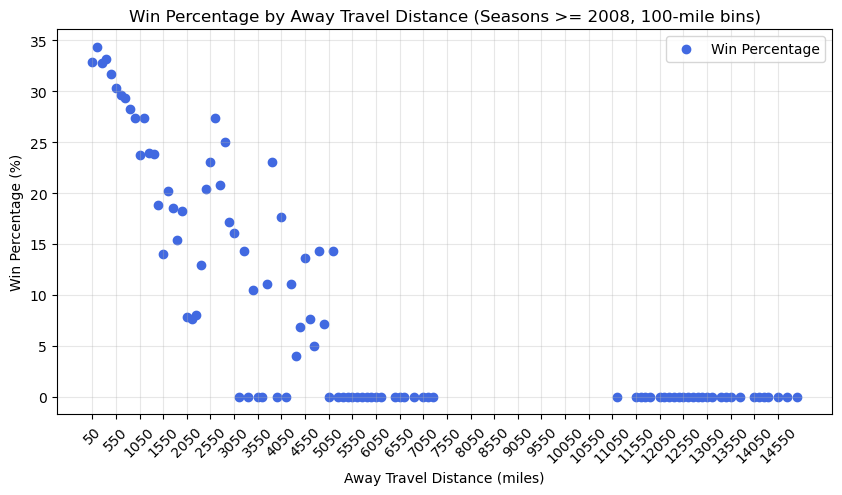

    Distance Bin  Number of Games  Win Percentage
0           0-99            12472           32.90
1        100-199            14857           34.35
2        200-299            13628           32.81
3        300-399            10213           33.15
4        400-499             6588           31.66
5        500-599             5409           30.34
6        600-699             4701           29.65
7        700-799             3660           29.29
8        800-899             2856           28.26
9        900-999             2431           27.40
10     1000-1099             1460           23.77
11     1100-1199             1259           27.40
12     1200-1299              849           23.91
13     1300-1399              579           23.83
14     1400-1499              553           18.81
15     1500-1599              462           14.07
16     1600-1699              460           20.22
17     1700-1799              416           18.51
18     1800-1899              332           15.36


In [66]:
# Filter Mgames for seasons >= 2010
Mgames_filtered = Mgames[Mgames['Season'] >= 2010]

# Define bins for travel distance (100-mile intervals)
bin_edges = np.arange(0, Mgames_filtered['away_travel_distance'].max() + 100, 100)
bin_labels = [f"{int(low)}-{int(high-1)}" for low, high in zip(bin_edges[:-1], bin_edges[1:])]

# Assign each game to a distance bin
Mgames_filtered['distance_bin'] = pd.cut(Mgames_filtered['away_travel_distance'], bins=bin_edges, labels=bin_labels, right=False)

# Calculate win percentage per bin
win_percentage = (
    Mgames_filtered.groupby('distance_bin')['WLoc']
    .apply(lambda x: (x == 'A').mean())  # 'A' means away team won
    .reset_index()
    .rename(columns={'WLoc': 'win_percentage'})
)

# Convert labels to numerical midpoints for plotting
bin_midpoints = bin_edges[:-1] + 50  # Midpoint of each 100-mile bin
win_percentage['bin_midpoint'] = bin_midpoints[:len(win_percentage)]

# Plot the results
plt.figure(figsize=(10, 5))

# Dot plot (Only scatter points, no line)
plt.scatter(win_percentage['bin_midpoint'], win_percentage['win_percentage'] * 100, 
            color='royalblue', label='Win Percentage')

# Customize the plot
plt.xlabel("Away Travel Distance (miles)")
plt.ylabel("Win Percentage (%)")
plt.title("Win Percentage by Away Travel Distance (Seasons >= 2008, 100-mile bins)")

# Show every 5th label on the x-axis
plt.xticks(bin_midpoints[::5], rotation=45)

plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Count the number of games in each distance bin
bin_counts = Mgames_filtered['distance_bin'].value_counts().sort_index().reset_index()
bin_counts.columns = ['Distance Bin', 'Number of Games']

# Merge with win percentage data
bin_summary = win_percentage.merge(bin_counts, left_on='distance_bin', right_on='Distance Bin')

# Select and reorder columns
bin_summary = bin_summary[['Distance Bin', 'Number of Games', 'win_percentage']]
bin_summary = bin_summary.rename(columns={'win_percentage': 'Win Percentage'})

# Convert win percentage to percentage format
bin_summary['Win Percentage'] = (bin_summary['Win Percentage'] * 100).round(2)

# Display the table
pd.set_option('display.max_rows', None)  # Ensure all rows are shown
print(bin_summary)

pd.reset_option('display.max_rows')

### Home Field Advantage and Travel Effect (Womens)

- Interestingly, look very different from the Mens chart. Starting initially higher and with slope much closer to 0. These results suggest that the home field advantage and travel effect are not as important for the Womens as the mens. One hypothosis is that for most schools, Mens basketball is a bigger sport than Womens, which leads to larger crowds and less of a home field advatage effect. It is worth exploring this difference further.

- True away teams with little travel times have approximately a 40.5% win perctentage, so I've given Womens true home teams 80 Elo Point boost.

- I used 4x^(1/5) to model the Travel distance Elo penalty.



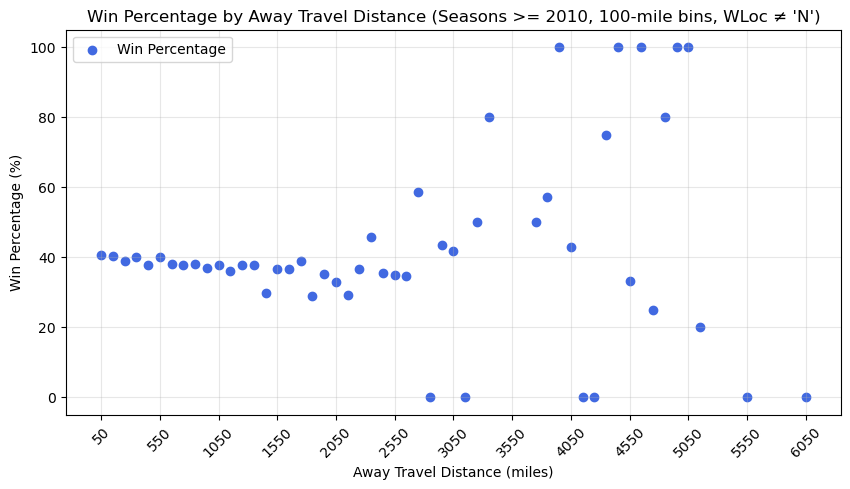

   Distance Bin  Number of Games  Win Percentage
0          0-99            12020           40.52
1       100-199            14576           40.33
2       200-299            12752           39.04
3       300-399             9048           40.19
4       400-499             5600           37.70
5       500-599             4419           40.01
6       600-699             3748           38.18
7       700-799             2922           37.75
8       800-899             2269           38.12
9       900-999             1896           36.87
10    1000-1099              959           37.64
11    1100-1199              877           36.03
12    1200-1299              637           37.83
13    1300-1399              358           37.71
14    1400-1499              336           29.76
15    1500-1599              237           36.71
16    1600-1699              224           36.61
17    1700-1799              234           38.89
18    1800-1899              156           28.85
19    1900-1999     

In [21]:
# Filter Wgames for seasons >= 2010 and where WLoc is not 'N'
Wgames_filtered = Wgames[(Wgames['Season'] >= 2010) & (Wgames['WLoc'] != 'N')]

# Define bins for travel distance (100-mile intervals)
bin_edges = np.arange(0, Wgames_filtered['away_travel_distance'].max() + 100, 100)
bin_labels = [f"{int(low)}-{int(high-1)}" for low, high in zip(bin_edges[:-1], bin_edges[1:])]

# Assign each game to a distance bin
Wgames_filtered['distance_bin'] = pd.cut(Wgames_filtered['away_travel_distance'], bins=bin_edges, labels=bin_labels, right=False)

# Calculate win percentage per bin
win_percentage = (
    Wgames_filtered.groupby('distance_bin')['WLoc']
    .apply(lambda x: (x == 'A').mean())  # 'A' means away team won
    .reset_index()
    .rename(columns={'WLoc': 'win_percentage'})
)

# Convert labels to numerical midpoints for plotting
bin_midpoints = bin_edges[:-1] + 50  # Midpoint of each 100-mile bin
win_percentage['bin_midpoint'] = bin_midpoints[:len(win_percentage)]

# Plot the results
plt.figure(figsize=(10, 5))

# Dot plot (Only scatter points, no line)
plt.scatter(win_percentage['bin_midpoint'], win_percentage['win_percentage'] * 100, 
            color='royalblue', label='Win Percentage')

# Customize the plot
plt.xlabel("Away Travel Distance (miles)")
plt.ylabel("Win Percentage (%)")
plt.title("Win Percentage by Away Travel Distance (Seasons >= 2010, 100-mile bins, WLoc ≠ 'N')")

# Show every 5th label on the x-axis
plt.xticks(bin_midpoints[::5], rotation=45)

plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Count the number of games in each distance bin
bin_counts = Wgames_filtered['distance_bin'].value_counts().sort_index().reset_index()
bin_counts.columns = ['Distance Bin', 'Number of Games']

# Merge with win percentage data
bin_summary = win_percentage.merge(bin_counts, left_on='distance_bin', right_on='Distance Bin')

# Select and reorder columns
bin_summary = bin_summary[['Distance Bin', 'Number of Games', 'win_percentage']]
bin_summary = bin_summary.rename(columns={'win_percentage': 'Win Percentage'})

# Convert win percentage to percentage format
bin_summary['Win Percentage'] = (bin_summary['Win Percentage'] * 100).round(2)

# Display the table
pd.set_option('display.max_rows', None)  # Ensure all rows are shown
print(bin_summary)

pd.reset_option('display.max_rows')


## Elo Ratings (Mens)

Finally the good part

I won't explain the Elo Rating System, that can be found at https://en.wikipedia.org/wiki/Elo_rating_system.

I will defend everything I've added however starting with parameters.

### Parameters

#### K
K describes is how sensative the system is, higher k resulting in more fluctuations in ratings. Too low of a K and the system will lag behind a teams true rating and if K is too large its putting to much weight onto recent games. To put this in persepective of sports, in a game with high variability like baseball, you will want a smaller K than a sport with low variablity such as basketball, and football probably somewhere inbetween.

I chose K = 42, this was mostly a trial and error process, deviating slightly from K values in other models I researched online until I came to a rating system that appropriately valued top teams.

#### Reversion Factor
Due to the NBA draft and now transfer portal, its not common for Mens teams to return a large amount of players, especially if the team was very good. Thus I wanted to add a reversion factor that would pull teams closer to the mean of their conference after each season.

I chose .35 which was somewhat arbitrary, Mens teams often change greatly from year to year and I wanted a reversion factor that supported that.

I also took the conference a team was in and assumed that they've been in that conference from the beginning of the dataset due to time constraints, obviously updating team's conference as they've changed conference is an area of improvement

PARAMETER NOTES: The parameters are an area of improvement, mostly chosen arbituarly justified by research, I would like to develop parameters with more mathematical support. 

### Pregame Adustments

There are 2 pregame adjustments I've made to team:

- The home team (If there is one) is given 110 Elo Points.

- The away team (and home team if neutral site game) travel distance penalty is applied.


### Weights

- I then applied weights to each type of game, also chosen somewhat arbituary. NCAA Tournament games reveal more information about teams and are the most important games of the season, also Conference tournaments to a less extent.

### Point Differential

- Point differential was also taken into account The model being a multiplier of ((PD+3)^.85) / (7.5+.006*Elo_diff) where PD is the point differential and Elo_diff is the difference in elo. This function is a variation of the Point differential used by Nate Silver.


In [122]:
def M_elo_calc (teams, data, initial_elo = 1500, k = 42, revert_factor = .35):

    #Innitialize Values
    conf_dict = dict(zip(Mteams['TeamID'], Mteams['Conf']))
    elo_dict = {team: initial_elo for team in teams}
    # Expected Outcome
    for i, row in data.iterrows():

        if row['type'] == 'regular season':
            weight = 1
        elif row['type'] == 'conf tournament':
            weight = 1.15
        elif row['type'] == 'ncaa tournament':
            weight = 1.3

        # Home team adjustment
        if row['WLoc'] != 'N':
            H_adj = elo_dict[row['HTeamID']] + 110
        else:
            H_adj = elo_dict[row['HTeamID']]

        A_adj = elo_dict[row['ATeamID']]
        if pd.notna(row['home_travel_distance']) and pd.notna(row['away_travel_distance']):
            H_adj = H_adj - (7*row['home_travel_distance']**(1/4))
            A_adj = A_adj - (7*row['away_travel_distance']**(1/4))
        
        H_exp = 1/(1+10**((A_adj - H_adj)/400))
        A_exp = 1 - H_exp

        elo_diffH = H_adj - A_adj
        elo_diffA = -elo_diffH
        # Udating Elo
        if row['WTeamID'] == row['HTeamID']:
            PD = abs(row['WScore'] - row['LScore'])
            PD_mult = ((PD+3)**.85) / (7.5+.006*elo_diffH)
            elo_dict[row['HTeamID']] += k * (1 - H_exp) * PD_mult * weight
            elo_dict[row['ATeamID']] += k * (0 - A_exp) * PD_mult * weight

        else:
            PD = row['WScore'] - row['LScore']
            PD_mult = ((PD+3)**.85) / (7.5+.006*elo_diffA)
            elo_dict[row['HTeamID']] += k * (0 - H_exp) * PD_mult * weight
            elo_dict[row['ATeamID']] += k * (1 - A_exp) * PD_mult * weight

        if row['DayNum'] == 154:

            conf_mean_elo = {}
            for team, conf in conf_dict.items():
                conf_mean_elo.setdefault(conf, []).append(elo_dict[team])

            # Compute average Elo per conference
            conf_mean_elo = {conf: sum(elos) / len(elos) for conf, elos in conf_mean_elo.items()}

            # Adjust each team towards their conference mean
            for team, conf in conf_dict.items():
                if conf in conf_mean_elo:
                    elo_dict[team] += revert_factor * (conf_mean_elo[conf] - elo_dict[team])
    return elo_dict

Mostly similiar stuff for the womens, I used a smaller reversion factor as the WNBA is less appealing than its male counterpart. The transfer portal and graduation still exist however. 

In [123]:
def W_elo_calc (teams, data, initial_elo = 1500, k = 42, revert_factor = .20):

    #Innitialize Values
    conf_dict = dict(zip(Wteams['TeamID'], Wteams['Conf']))
    elo_dict = {team: initial_elo for team in teams}
    # Expected Outcome
    for i, row in data.iterrows():

        if row['type'] == 'regular season':
            weight = 1
        elif row['type'] == 'conf tournament':
            weight = 1.05
        elif row['type'] == 'ncaa tournament':
            weight = 1.3

        # Home team adjustment
        if row['WLoc'] != 'N':
            H_adj = elo_dict[row['HTeamID']] + 80
        else:
            H_adj = elo_dict[row['HTeamID']]

        A_adj = elo_dict[row['ATeamID']]
        if pd.notna(row['home_travel_distance']) and pd.notna(row['away_travel_distance']):
            H_adj = H_adj - (4*row['home_travel_distance']**(1/5))
            A_adj = A_adj - (4*row['away_travel_distance']**(1/5))
        
        H_exp = 1/(1+10**((A_adj - H_adj)/400))
        A_exp = 1 - H_exp

        elo_diffH = H_adj - A_adj
        elo_diffA = -elo_diffH
        # Udating Elo
        if row['WTeamID'] == row['HTeamID']:
            PD = abs(row['WScore'] - row['LScore'])
            PD_mult = ((PD+3)**.85) / (7.5+.006*elo_diffH)
            elo_dict[row['HTeamID']] += k * (1 - H_exp) * PD_mult * weight
            elo_dict[row['ATeamID']] += k * (0 - A_exp) * PD_mult * weight

        else:
            PD = row['WScore'] - row['LScore']
            PD_mult = ((PD+3)**.85) / (7.5+.006*elo_diffA)
            elo_dict[row['HTeamID']] += k * (0 - H_exp) * PD_mult * weight
            elo_dict[row['ATeamID']] += k * (1 - A_exp) * PD_mult * weight

        if row['DayNum'] == 154:
            conf_mean_elo = {}
            for team, conf in conf_dict.items():
                conf_mean_elo.setdefault(conf, []).append(elo_dict[team])

            # Compute average Elo per conference
            conf_mean_elo = {conf: sum(elos) / len(elos) for conf, elos in conf_mean_elo.items()}

            # Adjust each team towards their conference mean
            for team, conf in conf_dict.items():
                if conf in conf_mean_elo:
                    elo_dict[team] += revert_factor * (conf_mean_elo[conf] - elo_dict[team])
            
    return elo_dict

### Results

Male Elo Rating

In [124]:
Mens_elo = M_elo_calc(Mteams.TeamID, Mgames)

In [125]:
Mteam_mapping = dict(zip(Mteams['TeamID'], Mteams['TeamName']))
Melo_named_dict = {Mteam_mapping[tid]: elo for tid, elo in Mens_elo.items()}
elo_M = pd.DataFrame(Melo_named_dict.items(), columns=['TeamName', 'Elo Rating'])
elo_M = elo_M.sort_values(by='Elo Rating', ascending=False).head(50).reset_index(drop=True)


print(elo_M)

          TeamName   Elo Rating
0          Houston  2155.324287
1          Florida  2148.120318
2             Duke  2136.473043
3        St John's  2083.438614
4           Auburn  2069.516229
5      Michigan St  2054.663612
6        Tennessee  2026.892993
7          Alabama  2003.801211
8         Maryland  1996.718968
9          Gonzaga  1995.272338
10         Arizona  1986.628103
11         Clemson  1981.850638
12      Texas Tech  1978.164144
13     Connecticut  1973.522956
14       Wisconsin  1966.943052
15             BYU  1961.671716
16      Louisville  1953.891051
17    St Mary's CA  1948.388565
18         Iowa St  1943.039275
19     Colorado St  1935.152410
20        Illinois  1914.228850
21       Marquette  1903.894344
22        Michigan  1903.813756
23             VCU  1903.242178
24       Creighton  1902.852952
25    UC San Diego  1902.690607
26         Memphis  1896.325357
27           Drake  1891.103602
28       Texas A&M  1888.854824
29      New Mexico  1887.286143
30      

### Results
Womens Elo Rating

In [126]:
Womens_elo = W_elo_calc(Wteams.TeamID, Wgames)

In [127]:
Wteam_mapping = dict(zip(Wteams['TeamID'], Wteams['TeamName']))
Welo_named_dict = {Wteam_mapping[tid]: elo for tid, elo in Womens_elo.items()}
elo_W = pd.DataFrame(Welo_named_dict.items(), columns=['TeamName', 'Elo Rating'])
elo_W = elo_W.sort_values(by='Elo Rating', ascending=False).head(50).reset_index(drop=True)


print(elo_W)

          TeamName   Elo Rating
0   South Carolina  2570.280316
1      Connecticut  2553.694148
2            Texas  2443.244082
3             UCLA  2428.387233
4              USC  2409.180671
5             Duke  2346.933539
6         NC State  2345.969456
7              LSU  2344.289758
8       Notre Dame  2337.591602
9             Iowa  2268.473416
10             TCU  2227.773108
11          Baylor  2211.692991
12        Oklahoma  2204.323911
13       Creighton  2203.023239
14     Mississippi  2192.286265
15         Ohio St  2190.092985
16  North Carolina  2177.281300
17        Michigan  2159.913943
18   West Virginia  2148.750518
19      Louisville  2136.583283
20        Kentucky  2133.055257
21         Alabama  2129.431064
22       Tennessee  2116.123899
23      Florida St  2113.800117
24         Iowa St  2105.686811
25     Oklahoma St  2092.775614
26        Maryland  2086.682462
27      California  2084.257590
28     Michigan St  2084.240957
29       Kansas St  2062.188230
30      